In [1]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path dataset berada di sini', path)
print('Isi dari path ini adalah', os.listdir(path))

Using Colab cache for faster access to the 'airlines-flights-data' dataset.
Path dataset berada di sini /kaggle/input/airlines-flights-data
Isi dari path ini adalah ['airlines_flights_data.csv']


In [2]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
df.drop(columns='index', inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


**PREPROCESSING**

In [4]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [5]:
Features = ['source_city','departure_time','stops','arrival_time',
            'destination_city','class','days_left']

In [6]:
X = df[Features]
y = df['price']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
print(f"Data training berjumlah :{len(X_train)} dan data uji berjumlah : {len(X_test)}")

Data training berjumlah :240122 dan data uji berjumlah : 60031


In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

scaler = StandardScaler()
num_feat = ['days_left']
num_transform = scaler

In [10]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = ['source_city','departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [11]:
df['class'].unique()

array(['Economy', 'Business'], dtype=object)

In [12]:
ordinal_features = ['class']
class_categories = ['Economy','Business']
ordinal_transform = OrdinalEncoder(categories=[class_categories])

In [13]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('log', log_transform),
        ('scaler', num_transform)
    ]), num_feat),
    ('ord', ordinal_transform, ordinal_features),
    ('cat', cat_transform, cat_feat)
], remainder='drop')

In [15]:
from xgboost import XGBRegressor

XGB = XGBRegressor(objective='reg:squarederror', random_state=42)

In [16]:
from sklearn.compose import TransformedTargetRegressor

model_XGB = TransformedTargetRegressor(
    regressor = XGB,
    func = np.log1p,
    inverse_func= np.expm1
)

In [17]:
XGB_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_XGB)
])

**HYPERPARAMETER TUNING**

In [21]:
params_grid_XGB = {
    'regressor__regressor__n_estimators' : [150, 200, 300],
    'regressor__regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__regressor__max_depth' : [10, 15, 20],
}

In [22]:
from sklearn.model_selection import GridSearchCV

gridsearch_XGB = GridSearchCV(
    estimator= XGB_pipeline,
    param_grid = params_grid_XGB,
    cv = 5,
    scoring = 'r2',
    n_jobs=-1,
    verbose=2
)

In [23]:
gridsearch_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['days_left']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Business']]),
                                                                         ['class']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                                          max_leaves=None,
                                                                                          min_child_weight=None,
                                                                                          missing=nan,
                                                                                          monotone_constraints=None,
                                                                                          multi_strategy=None,
                                                                                          n_estimators=None,
                                                                                          n_jobs=None,
                                                                                          num_parallel_tree=None, ...)))]),
             n_jobs=-1,
             param_grid={'regressor__regressor__learning_rate': [0.05, 0.1,
                                                                 0.2],
                         'regressor__regressor__max_depth': [10, 15, 20],
                         'regressor__regressor__n_estimators': [150, 200, 300]},
             scoring='r2', verbose=2)

In [24]:
best_XGB = gridsearch_XGB.best_estimator_

**EVALUATE MODEL**

In [26]:
print("Best Params yang ditemukan adalah : ", gridsearch_XGB.best_params_)
print("Best CV Score yang ditemukan adalah :", gridsearch_XGB.best_score_)

Best Params yang ditemukan adalah :  {'regressor__regressor__learning_rate': 0.05, 'regressor__regressor__max_depth': 10, 'regressor__regressor__n_estimators': 200}
Best CV Score yang ditemukan adalah : 0.955452024936676


In [27]:
print(best_XGB)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [28]:
y_pred = best_XGB.predict(X_test)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('=== Evaluasi Model ===')
r2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'Best r2 socre yang dihasilkan adalah : {r2:.4f}')
print(f'Best MAE score yang dihasilkan adalah : {MAE:.4f}')
print(f'Best RMSE score yang dihasilkan adalah : {RMSE:.4f}')

=== Evaluasi Model ===
Best r2 socre yang dihasilkan adalah : 0.9552
Best MAE score yang dihasilkan adalah : 2761.8459
Best RMSE score yang dihasilkan adalah : 4803.6099


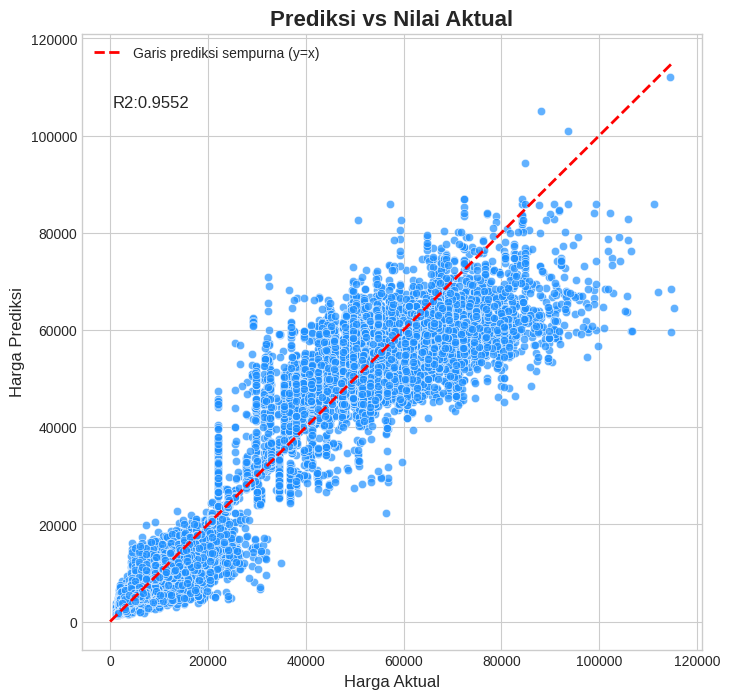

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color = 'dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val],[0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual', fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05,0.9, f'R2:{r2:.4f}', transform=plt.gca(). transAxes, fontsize=12, verticalalignment='top')
plt.show()

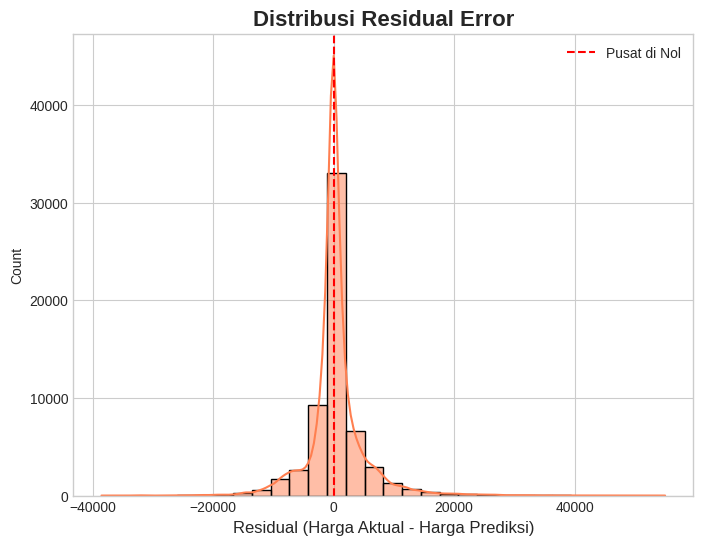

In [31]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nol')
plt.legend()
plt.show()

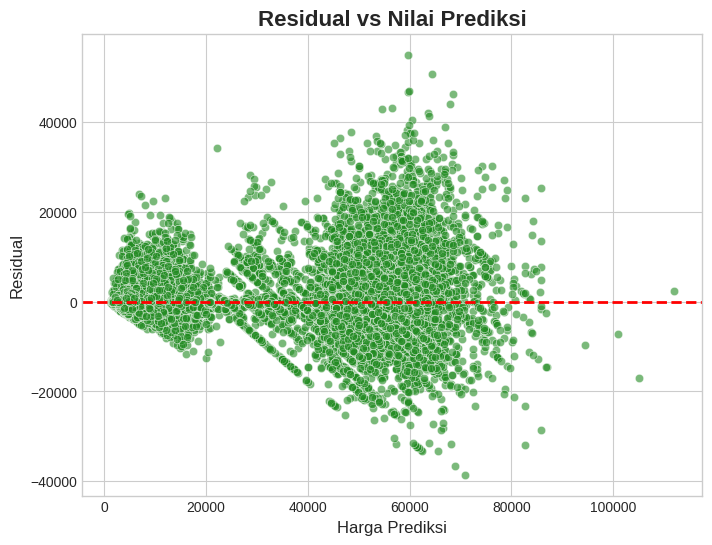

In [32]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()


In [37]:
# Mengambil step preprocessor dan regressor (XGBoost)

preprocessor = best_XGB.named_steps['preprocessor']
model = best_XGB.named_steps['regressor'].regressor_

In [38]:
# Ambil fitur numerik
num_features = preprocessor.transformers_[0][2]

# Ambil fitur ordinal
ord_features = preprocessor.transformers_[1][2]

# Ambil fitur kategori (one-hot)
ohe = preprocessor.transformers_[2][1]
cat_features = preprocessor.transformers_[2][2]
ohe_features = list(ohe.get_feature_names_out(cat_features))


# Gabungkan semuanya
all_features = list(num_features) + list(ord_features) + ohe_features


In [39]:
# Feature importance dari model XGBoost
importances = model.feature_importances_

# Buat dataframe
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


In [40]:
feature_importance_df

,Feature,Importance
0,class,0.872466
1,stops_zero,0.094788
2,days_left,0.005866
3,source_city_Kolkata,0.002983
4,destination_city_Kolkata,0.002371
5,arrival_time_Late_Night,0.001704
6,stops_one,0.001580
7,source_city_Delhi,0.001528
8,destination_city_Delhi,0.001303
9,source_city_Bangalore,0.001160


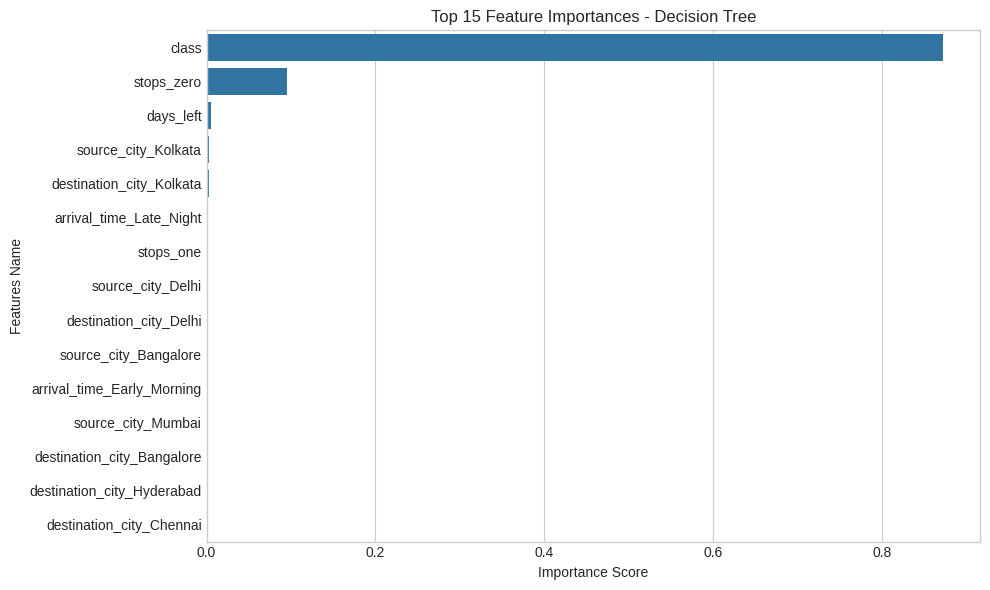

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features Name')
plt.tight_layout()
plt.show()

In [42]:
from google.colab import files
import joblib

joblib.dump(best_XGB, 'XGBoost_prediction_flight_ticket.pkl')
files.download('XGBoost_prediction_flight_ticket.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>